# Cargamos las librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

## Cargamos los archivos y hacemos el EDA

In [2]:
comercios = pd.read_csv("commerces.csv", sep=",")
print(comercios.shape)
print(comercios['district'].unique())
comercios.head()

(100, 2)
['Providencia' 'Penalolen' 'Nunoa' 'Macul' 'La Florida']


,id_commerce,district
0,1,Providencia
1,2,Penalolen
2,3,Penalolen
3,4,Nunoa
4,5,Nunoa


In [3]:
comercios.isnull().sum()

id_commerce    0
district       0
dtype: int64

In [175]:
productos = pd.read_csv("product.csv", sep=",")
print(productos.shape)
print(f"Categorias : {list(productos['category'].unique())}")
print(f"Productos distintos para vender : {productos['id_product'].nunique()}")
productos.head()

(50, 4)
Categorias : ['Hogar', 'Electrónica', 'Alimentos', 'Ropa', 'Juguetes']
Productos distintos para vender : 50


,id_product,name,category,price
0,1,Producto 1,Hogar,54
1,2,Producto 2,Electrónica,76
2,3,Producto 3,Hogar,67
3,4,Producto 4,Alimentos,95
4,5,Producto 5,Ropa,95


In [5]:
productos.isnull().sum()

id_product    0
name          0
category      0
price         0
dtype: int64

In [6]:
ventas = pd.read_csv("transactions.csv", sep=",")
print(ventas.shape)
ventas.head()

(500000, 4)


,id_commerce,id_product,quantity,price
0,27,17,6,324
1,64,50,7,693
2,49,5,4,380
3,58,22,4,168
4,9,33,7,343


In [7]:
ventas.isnull().sum()

id_commerce    0
id_product     0
quantity       0
price          0
dtype: int64

In [8]:
ventas.describe()

,id_commerce,id_product,quantity,price
count,500000.000000,500000.000000,500000.000000,500000.000000
mean,50.540948,25.495818,5.004330,283.329010
std,28.842359,14.421320,2.585476,206.799043
min,1.000000,1.000000,1.000000,10.000000
25%,26.000000,13.000000,3.000000,108.000000
50%,51.000000,25.000000,5.000000,240.000000
75%,76.000000,38.000000,7.000000,415.000000
max,100.000000,50.000000,9.000000,891.000000


## Ahora que ya hemos visto la data y chequeado que no hay valores nulos, procedemos a verificar cuantos productos distintos vende cada negocio

Todos los comercios venden los 50 productos


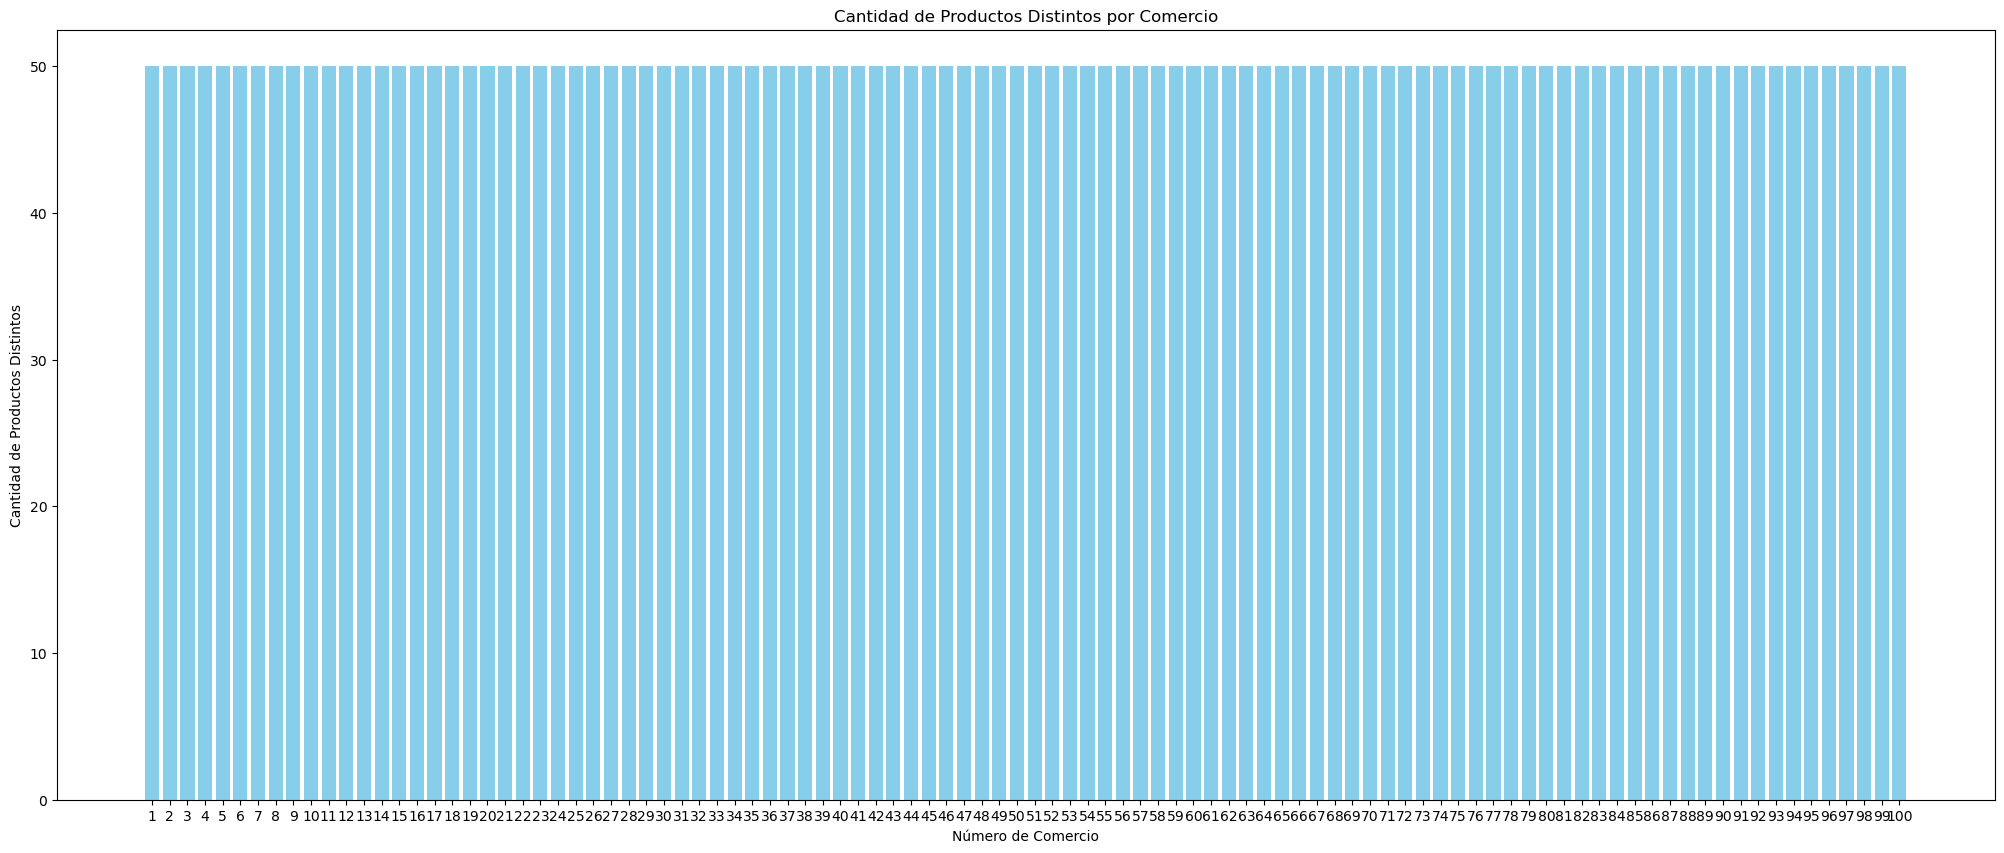

In [191]:
# Agrupar por 'Comercio' y contar los productos únicos
productos_por_comercio = ventas.groupby('id_commerce')['id_product'].nunique().reset_index()

if productos_por_comercio['id_product'].unique() == 50:
    print("Todos los comercios venden los 50 productos")
else:
    print("No todos los comercios venden 50 productos")

# Ordenar por el número del comercio
productos_por_comercio = productos_por_comercio.sort_values('id_commerce')

# Graficar los resultados
plt.figure(figsize=(25, 10))
plt.bar(productos_por_comercio['id_commerce'], productos_por_comercio['id_product'], color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Número de Comercio')
plt.ylabel('Cantidad de Productos Distintos')
plt.title('Cantidad de Productos Distintos por Comercio')
plt.xticks(productos_por_comercio['id_commerce'])  # Asegura que los números de comercio aparezcan como ticks

# Mostrar gráfico
plt.show()

### Dado que todos los comercios venden los 50 productos, probablemente haya que modificar el código para el sistema de recomendación de acuerdo al comercio y la categoría

## Ahora hacemos el merge para obtener informacion sobre el producto y la comuna

In [33]:
df = ventas.merge(comercios, how='left', on='id_commerce')\
        .merge(productos, how='left', on='id_product')\
            .rename(columns={'price_x':'precio_total',
                             'price_y':'precio_unitario'})
df.head()

,id_commerce,id_product,quantity,precio_total,district,name,category,precio_unitario
0,27,17,6,324,Macul,Producto 17,Alimentos,54
1,64,50,7,693,Nunoa,Producto 50,Ropa,99
2,49,5,4,380,Penalolen,Producto 5,Ropa,95
3,58,22,4,168,Providencia,Producto 22,Electrónica,42
4,9,33,7,343,La Florida,Producto 33,Alimentos,49


In [36]:
len(df['id_commerce'].unique())

100

In [32]:
df_categorias = df[(df['district'] == "Macul")].groupby('category')[['quantity','precio_total']].sum().reset_index()
df_categorias

,category,quantity,precio_total
0,Alimentos,67805,4083052
1,Electrónica,75202,3992991
2,Hogar,75851,3328320
3,Juguetes,59999,4208010
4,Ropa,97198,5660170


In [25]:
df_subset = df[(df['district'] == "Macul") & (df['category'] == "Juguetes")]
print(f"Productos en venta: {df_subset['id_product'].nunique()}")
print(f"Comercios que venden estos productos: {df_subset['id_commerce'].nunique()}")

Productos en venta: 8
Comercios que venden estos productos: 15


In [55]:
df_subset_productos = df_subset.groupby('id_product')['quantity'].sum().reset_index()

In [60]:
scaler = MinMaxScaler()

df_subset_productos['quantity_scaled'] = scaler.fit_transform(df_subset_productos[['quantity']])
df_subset_productos.sort_values(by=['quantity_scaled'], ascending=False)

,id_product,quantity,quantity_scaled
4,30,7702,1.000000
5,34,7657,0.897260
2,14,7568,0.694064
3,24,7524,0.593607
0,7,7449,0.422374
6,35,7429,0.376712
7,42,7406,0.324201
1,8,7264,0.000000


## Armamos la funcion para obtener la similitud entre los comercios

In [215]:
def similitud_comercios(categoria, comuna):
    df_temp = df[(df['category'] == categoria) & (df['district'] == comuna)]
    
    # Crear la matriz de compras (comercio vs producto)
    matriz_compras = df_temp.pivot_table(index='id_commerce', columns='id_product', values='quantity', aggfunc='sum').fillna(0)
    
    # Aplicar MinMaxScaler para escalar los valores entre 0 y 1
    scaler = MinMaxScaler()
    matriz_compras_scaled = scaler.fit_transform(matriz_compras)
    
    # Calcular la similitud entre comercios
    similitud_comercios = cosine_similarity(matriz_compras_scaled)
    
    # Convertir la similitud en un DataFrame
    similitud_comercios_df = pd.DataFrame(similitud_comercios, index=matriz_compras.index, columns=matriz_compras.index)
    
    return similitud_comercios_df

# Armamos la funcion para obtener nuestro sistema de recomendación

In [223]:
# Función para recomendar productos basados en la popularidad en comercios similares
def recomendar_productos():
    # Damos la bienvenida al sistema
    print("¡Bienvenido al sistema de recomendación de productos!")
    print("\n")
    
    # Buscamos el listado de comercios, categorias y solicitamos el número de comercio al cliente
    listado_comercios = comercios['id_commerce'].unique()
    listado_categorias = productos['category'].unique()
    listado_metricas = ['Unidades', 'Ventas']
    
    numero_comercio = int(input("Por favor indique su número de comercio: "))
    
    while numero_comercio not in listado_comercios:
        numero_comercio = int(input("Comercio no válido. Por favor ingrese su numero de comercio (1 al 100): "))
    else:
        # Filtrar comercios en la misma comuna
        comuna_comercio = comercios[comercios['id_commerce'] == numero_comercio]['district'].iloc[0]
        comercios_comuna = df[df['district'] == comuna_comercio]['id_commerce'].unique()
        
        # Se selecciona la categoria
        print("\n")
        print("Categorías disponibles:")
        for idx, cat in enumerate(listado_categorias, start=1):
            print(f"{idx}. {cat}")
        
        categoria_seleccionada = str(input("Seleccione una categoria: "))
         
        while categoria_seleccionada not in listado_categorias:
            categoria_seleccionada = str(input("Categoría no válida. Favor seleccionar una categoría disponible: "))
        
        else:
            # Obtenemos la matriz de similitud
            similitud_comercios_df = similitud_comercios(categoria_seleccionada, comuna_comercio)
            
            # Obtener las similitudes de los comercios de la misma comuna
            similitudes_comuna = similitud_comercios_df.loc[numero_comercio, comercios_comuna]
        
            # Filtrar: eliminar el comercio actual y los que tengan una similitud menor a 0.85
            similitudes_comuna = similitudes_comuna[similitudes_comuna.index != numero_comercio]
            similitudes_comuna = similitudes_comuna[similitudes_comuna >= 0.85]
        
            # Ordenar los comercios similares en la misma comuna por similitud (descendente)
            comercios_similares = similitudes_comuna.sort_values(ascending=False).index
                    
            # Inicializar una tabla de conteo de productos
            conteo_productos = pd.Series(dtype='float64')
        
            # Recorrer los comercios similares para acumular las cantidades de productos comprados
            for comercio_similar in comercios_similares:
               
                # Obtenemos los productos más comprados por ese comercio dentro de la categoría
                productos_similares = df[(df['id_commerce'] == comercio_similar) & 
                                         (df['category'] == categoria_seleccionada)][['id_product', 'quantity']]
                          
                # Acumular las cantidades compradas para cada producto
                conteo_productos = conteo_productos.add(productos_similares.groupby('id_product')['quantity']\
                                                        .sum(), fill_value=0)
    
                # Ordenar los productos por la cantidad acumulada de compras
                productos_recomendados = conteo_productos.sort_values(ascending=False).index[:10]
                productos_entregados = productos[productos['id_product'].isin(productos_recomendados)][['name', 'price']]
                        
    return print(f"\n Las recomendaciones de productos para el comercio {numero_comercio}, en la comuna de {comuna_comercio} para la categoria {categoria_seleccionada} son: "), print(productos_entregados)

## Hacemos el test

In [224]:
recomendar_productos()

¡Bienvenido al sistema de recomendación de productos!


Por favor indique su número de comercio: 4


Categorías disponibles:
1. Hogar
2. Electrónica
3. Alimentos
4. Ropa
5. Juguetes
Seleccione una categoria: Alimentos

 Las recomendaciones de productos para el comercio 4, en la comuna de Nunoa para la categoria Alimentos son: 
           name  price
3    Producto 4     95
8    Producto 9     19
14  Producto 15     82
16  Producto 17     54
18  Producto 19     98
25  Producto 26     24
26  Producto 27     68
32  Producto 33     49
35  Producto 36     55


(None, None)